Total energy now contains local density-density interactions

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd


torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"

data_regime = "rough" # "smooth" or "rough"

N_grid = 512 # number of grid points
if data_regime == "smooth":
    M_cutoff = 50 # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + m)**2
elif data_regime == "rough":
    M_cutoff = N_grid # maximum harmonic
    m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
    x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
    #design matrix needed to sample densities
    DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
    DerDM = -torch.pi * m[:, None] * torch.sin(torch.pi * torch.outer(m, x))  # (M, N) # derivative of design matrix
    std_harm = 2.0 / (1.0 + 0.0 * m)**2
else:
    raise ValueError("regime must be 'smooth' or 'rough'")

N_train = 1500
N_test = 250
N_val = 250

N_batch = 50
N_epochs = 10000
lr = 1e-3 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training


Setup the functional and sample density profiles 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


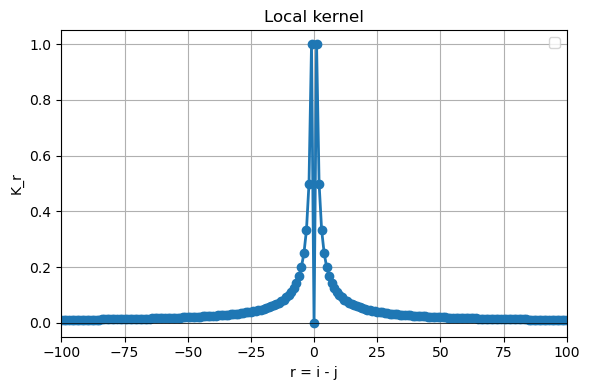

In [53]:
def sample_density(*, rho_b=0.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density has zero mean over the grid points
    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix
    d_rho_a = a @ DerDM  # derivative of rho w.r.t. x

    rho = rho - 0.0 * rho.mean()

    return rho, d_rho_a, a

def sample_density_batch(B: int, rho_b=0.0):
    """
    Sample a batch of B density profiles
    Spatial average density rho_avg is set to zero
    Returns rho: (B, N_grid)
    """

    a = torch.normal(torch.zeros(B, std_harm.numel(),dtype=dtype, device=device), std_harm.expand(B, -1))
    rho = a @ DesignMatrix  # (B, N_grid)
    d_rho_a = a @ DerDM  # (B, N_grid) # derivative of rho w.r.t. x

    rho = rho - 0.0 * rho.mean(dim=1, keepdim=True)
    return rho, d_rho_a, a

# density–density interaction kernels K(r)
# r: tensor (can be negative)
def K_gaussian(r, sigma=1.0):       # strictly local-ish
    r = r.to(dtype=dtype)
    return torch.exp(-(r**2) / (sigma**2))

def K_exp(r, xi=2.0):              # short–to–intermediate range
    r = r.to(dtype=dtype)
    return torch.exp(-torch.abs(r) / xi)

def K_yukawa(r, lam=10.0):
    r_abs = torch.abs(r).to(dtype=dtype)
    out = torch.exp(-r_abs / lam) / r_abs.clamp(min=1.0)
    return out * (r_abs > 0)     # zero at r == 0

def K_power(r, alpha=1.0):         # unscreened long range (Coulomb-like for alpha=1)
    r = torch.abs(r).to(dtype=dtype)
    out = 1.0 / (r.clamp(min=1.0)**alpha)
    return out * (r > 0)     # zero at r == 0

def E_int_conv(rho: torch.Tensor, kernel: str, **kwargs) -> torch.Tensor: 
    """
    Interaction energy using convolution
    rho: (N,) or (B, N)
    kernel: "gaussian", "exp", "yukawa", "power"
    kwargs: parameters for the kernel function (sigma, xi, lam, alpha, etc.)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    if kernel == "gaussian":
        K_fun = K_gaussian
    elif kernel == "exp":
        K_fun = K_exp
    elif kernel == "yukawa":
        K_fun = K_yukawa
    elif kernel == "power":
        K_fun = K_power
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

    # ensure batch dim
    if rho.dim() == 1:
        rho = rho.unsqueeze(0)
    B, N = rho.shape
    device, dtype = rho.device, rho.dtype

    # r = -(N-1)..(N-1), kernel length = 2N-1
    r_vals = torch.arange(-(N-1), N, device=device, dtype=dtype)  # (2N-1,)
    k_full = K_fun(r_vals, **kwargs)                              # (2N-1,)

    weight = k_full.view(1, 1, -1)                # (1,1,2N-1)
    u = F.conv1d(rho.unsqueeze(1), weight, padding=N-1).squeeze(1) # (B, N)
    E = 0.5 * (rho * u).sum(dim=-1) / N  # (B,)
    return E.squeeze(0) if E.numel() == 1 else E


lam = 10.0
alpha = 1.0
xi = 5.0
kernel_regime = "power"  

if kernel_regime == "power":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_conv(rho, kernel="power", alpha=alpha)
elif kernel_regime == "yukawa": 
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_conv(rho, kernel="yukawa", lam=lam)
elif kernel_regime == "exp":
    def E_tot(rho: torch.Tensor) -> torch.Tensor:
        return E_int_conv(rho, kernel="exp", xi=xi)

R = 100 
r_grid = torch.arange(-R, R+1)

plt.figure(figsize=(6,4))
if kernel_regime == "yukawa":
    plt.plot(r_grid, K_yukawa(r_grid, lam=lam), 'o-', linewidth=2) 
elif kernel_regime == "power":
    plt.plot(r_grid, K_power(r_grid, alpha=alpha), 'o-', linewidth=2) 
elif kernel_regime == "exp":
    plt.plot(r_grid, K_exp(r_grid, xi=xi), 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
# plt.ylim((0.0, 1.0))
plt.title(f"Local kernel")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Feature processing (generation and normalization)

In [54]:
# we save features as (B, N_grid, N_feat), where N_feat is the number of features per grid point
# generate train/test split

def compute_normalization_stats(features):
    """
    Compute mean and std for features with shape (N_data, N_grid, N_feat)
    Averages over both data and spatial dimensions
    
    Args:
        features: torch.Tensor of shape (N_data, N_grid, N_feat)
    
    Returns:
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)
    """

    mean_feat = features.mean(dim=(0, 1), keepdim=True)  # Shape: (1, 1, N_feat)
    std_feat = features.std(dim=(0, 1), keepdim=True) # Shape: (1, 1, N_feat)
    
    return mean_feat, std_feat

def normalize_features(features, mean_feat, std_feat):
    """
    Normalize features using provided or computed statistics
    
    Args:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        mean: torch.Tensor of shape (1, 1, N_feat)
        std: torch.Tensor of shape (1, 1, N_feat)

    Returns:
        normalized_features: torch.Tensor of same shape as input
        mean: mean used for normalization
        std: std used for normalization
    """
    normalized_features = (features - mean_feat) / std_feat

    return normalized_features

def generate_loc_features_rs(rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density rho
    rs, real space   
    Args:
        rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form rho^k, k=1,...,N_feat
    """
    features = [rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

def generate_loc_features_ms(d_rho: torch.Tensor, N_feat=2) -> torch.Tensor:
    """
    Generate local features from density derivative d_rho
    ms, momentum space
    Args:
        d_rho: torch.Tensor of shape (B, N_grid)
        N_feat: int, number of features to generate

    Returns:
        features: torch.Tensor of shape (B, N_grid, N_feat)
        each feature is of the form d_rho^k, k=1,...,N_feat
    """
    features = [d_rho.unsqueeze(-1) ** k for k in range(1, N_feat + 1)]
    return torch.cat(features, dim=-1)

rho_train, d_rho_train, a_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test, d_rho_test, a_test = sample_density_batch(N_test)   # (N_test, N_grid)
rho_val, d_rho_val, a_val = sample_density_batch(N_val)    # (N_val, N_grid)

N_feat = 1 

features_train_rs = generate_loc_features_rs(rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_rs  = generate_loc_features_rs(rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_rs   = generate_loc_features_rs(rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train_ms = generate_loc_features_ms(d_rho_train, N_feat=N_feat)  # (N_train, N_grid, N_feat)
features_test_ms  = generate_loc_features_ms(d_rho_test, N_feat=N_feat)   # (N_test, N_grid, N_feat)
features_val_ms   = generate_loc_features_ms(d_rho_val, N_feat=N_feat)    # (N_val, N_grid, N_feat)

features_train = torch.cat([features_train_rs, features_train_ms], dim=-1)
features_test  = torch.cat([features_test_rs, features_test_ms], dim=-1)
features_val   = torch.cat([features_val_rs, features_val_ms], dim=-1)

targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,)
targets_val   = E_tot(rho_val)              # (N_val,)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

Learning models: 
(1) Symmetric kernel K_r in the window regime (we learn K_0, K_1, ..., K_R - R is the kernel range)
(2) Gaussian mixture kernel K_r = \sum_n A_n \exp(-r^2 / sigma_n^2)

In [55]:
class LearnableKernelConv1d(nn.Module):
    """
    Learnable 1D convolution kernel K_r with range R
    Produces phi = [K * rho] (linear convolution with padding)
    """
    def __init__(self, R=5, even_kernel=True, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.pad_mode = pad_mode
        self.even_kernel = even_kernel
        
        if even_kernel:
            # learn half + center: w[0] (center), w[1..R] (positive r)
            self.kernel_half = nn.Parameter(torch.randn(R+1) * 0.01)
        else:
            # fully unconstrained kernel of size 2R+1
            self.kernel = nn.Parameter(torch.randn(2*R+1) * 0.01)

    def build_kernel(self):
        """
        Returns kernel of shape (1,1,2R+1) as required by conv1d
        """
        if self.even_kernel:
            center = self.kernel_half[0:1]          # (1,)
            pos = self.kernel_half[1:]             # (R,)
            neg = pos.flip(0)               # symmetric
            full = torch.cat([neg, center, pos], dim=0)  # (2R+1,)
        else:
            full = self.kernel
        return full.view(1,1,-1)  # (out=1, in=1, kernel_size)

    def forward(self, rho):
        """
        rho: (B, N_grid)
        Returns: phi: (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        kernel = kernel.to(dtype=rho.dtype, device=rho.device)
        R = self.R
        
        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='constant', value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='reflect')
        else:
            raise ValueError("pad_mode must be zero or reflect")
        
        phi = F.conv1d(x, kernel, padding=0).squeeze(1)
        return phi

class KernelOnlyEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j} = (1 / 2N) * sum_{i} rho_i [K * rho]_i
    The kernel K is assumed local and learnable via convolution
    """

    def __init__(self, R=5):
        super().__init__()
        self.R = R
        self.kernel_conv = LearnableKernelConv1d(R, even_kernel=True, pad_mode="zero")

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        rho_norm = features[..., 0]          # (B, N_grid), isolate density
        rho = rho_norm * std_feat[0,0,0] + mean_feat[0,0,0]  # denormalize density

        # apply learnable convolution kernel
        phi = self.kernel_conv(rho)  # (B, N_grid) # in physical units

        local_energies = 0.5 * rho * phi       # (B, N_grid) # physical units
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,) # physical units
        
        total_energy_norm = (total_energy - E_mean) / E_std  # normalize for training

        return total_energy_norm
    
class GaussianMixtureKernelConv1d(nn.Module):
    """
    Learnable 1D kernel K_r represented as a sum of Gaussians:
        K(r) = sum_{n=1}^M A_n * exp(-r^2 / sigma_n^2)

    Produces phi = [K * rho] via conv1d.
    """

    def __init__(self, R: int, n_components: int, pad_mode: str = "zero"):
        super().__init__()
        self.R = R
        self.n_components = n_components
        self.pad_mode = pad_mode

        # r-grid as a buffer: [-R, ..., R] - still is a cutoff in real space
        r_vals = torch.arange(-R, R + 1, dtype=dtype)
        self.register_buffer("r_vals", r_vals)  # (2R+1,)

        # ---- amplitudes A_n (sorted at init) ----
        # sample, then sort descending so A_1 >= A_2 >= ... >= A_M
        amps = 0.01 * torch.randn(n_components, dtype=dtype)
        amps, _ = torch.sort(amps, descending=True)
        self.amplitudes = nn.Parameter(amps)

        # Log-sigmas so sigma_n = softplus(log_sigma_n) > 0
        init_sigmas = torch.arange(1, n_components+1, dtype=dtype)**2
        log_sigmas = torch.log(torch.expm1(init_sigmas))  # inverse softplus, so softplus(raw)=init_sigma
        self.log_sigmas = nn.Parameter(log_sigmas)

    def build_kernel(self):
        """
        Returns kernel of shape (1, 1, 2R+1) as required by conv1d.
        """
        # (2R+1,) -> (1, L)
        r = self.r_vals.view(1, -1)              # (1, 2R+1)
        r2 = r * r                               # r^2

        sigmas = F.softplus(self.log_sigmas) + 1e-8   # (M,)
        sigma2 = sigmas.view(-1, 1) ** 2              # (M,1)

        # contributions from each Gaussian: (M, L)
        # exp(-r^2 / sigma_n^2)
        gauss = torch.exp(-r2 / sigma2)          # (M, 2R+1)

        # weighted sum over components
        kernel_1d = (self.amplitudes.view(-1, 1) * gauss).sum(dim=0)  # (2R+1,)

        # conv1d expects (out_channels, in_channels, kernel_size)
        return kernel_1d.view(1, 1, -1)

    def forward(self, rho: torch.Tensor) -> torch.Tensor:
        """
        rho: (B, N_grid)
        Returns: phi = (K * rho): (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        R = self.R

        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="constant", value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="reflect")
        else:
            raise ValueError("pad_mode must be 'zero' or 'reflect'")

        phi = F.conv1d(x, kernel, padding=0).squeeze(1)   # (B, N)
        return phi


class GaussianMixtureEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j}
          = (1 / 2N) * sum_i rho_i [K * rho]_i

    K is parameterized as a sum of Gaussians in r.
    """

    def __init__(self, R=20, n_components=3, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.kernel_conv = GaussianMixtureKernelConv1d(
            R=R,
            n_components=n_components,
            pad_mode=pad_mode,
        )

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used

        Returns:
            total_energy_norm: (B,) - normalized total energy
        """
        # globals: std_feat, mean_feat, E_mean, E_std, N_grid must exist
        rho_norm = features[..., 0]          # (B, N_grid)
        rho = rho_norm * std_feat[0, 0, 0] + mean_feat[0, 0, 0]

        # apply Gaussian-mixture kernel
        phi = self.kernel_conv(rho)          # (B, N_grid)

        local_energies = 0.5 * rho * phi     # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid    # (B,)

        total_energy_norm = (total_energy - E_mean) / E_std
        return total_energy_norm

Intermediate routines for training + actual model exploration

In [56]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

def load_checkpoint(path, model_class, device="cpu"):
    """
    Loads a saved model checkpoint
    Returns:
        model: reconstructed and loaded model
        normalization: dict of normalization stats
        epoch: best epoch
        val_loss: best validation loss
    """
    ckpt = torch.load(path, map_location=device)
    config = ckpt["config"]
    model = model_class(**config).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    normalization = ckpt.get("normalization", None)
    epoch = ckpt.get("epoch", None)
    val_loss = ckpt.get("val_loss", None)
    return model, normalization, epoch, val_loss
    
def _run_epoch(model, loader, criterion, train: bool):
    if train:
        model.train()
    else:
        model.eval()
    running = 0.0
    n_batches = 0

    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if train:
                optimizer.zero_grad()

            total_pred = model(xb)               
            loss = criterion(total_pred, yb)        

            if train:
                loss.backward()
                optimizer.step()

            running += loss.item()
            n_batches += 1

    return running / max(1, n_batches)

def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    max_epochs=10000,
    patience=10,
    min_delta=1e-5,
    ckpt_dir="checkpoints",
    run_name=None,
    learning_regime="window",
):
    os.makedirs(ckpt_dir, exist_ok=True)

    best_val = math.inf
    best_state = None
    best_epoch = -1
    since_improved = 0

    hist = {"train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        train_loss = _run_epoch(model, train_loader, criterion, train=True)
        val_loss = _run_epoch(model, val_loader, criterion, train=False)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        improved = (best_val - val_loss) > min_delta
        if improved:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            since_improved = 0

            # save checkpoint with normalization stats
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_best.pt")
            if learning_regime == "window":
                torch.save({
                    "model_state_dict": best_state,
                    "epoch": best_epoch,
                    "val_loss": best_val,
                    "config": {
                        "R": model.R,
                    },
                    "normalization": {
                        "mean_feat": mean_feat.cpu(),
                        "std_feat":  std_feat.cpu(),
                        "E_mean":    E_mean.cpu(),
                        "E_std":     E_std.cpu(),
                        "N_grid":    int(N_grid),
                    }
                }, ckpt_path)
            elif learning_regime == "gaussmixt":
                torch.save({
                    "model_state_dict": best_state,
                    "epoch": best_epoch,
                    "val_loss": best_val,
                    "config": {
                        "n_components": model.kernel_conv.n_components,                    },
                    "normalization": {
                        "mean_feat": mean_feat.cpu(),
                        "std_feat":  std_feat.cpu(),
                        "E_mean":    E_mean.cpu(),
                        "E_std":     E_std.cpu(),
                        "N_grid":    int(N_grid),
                    }
                }, ckpt_path)
        else:
            since_improved += 1

        if (epoch % 10) == 0 or epoch == 1:
            print(f"[{epoch:04d}] train={train_loss:.6f} | val={val_loss:.6f} "
                  f"| best_val={best_val:.6f} (epoch {best_epoch})")

        if since_improved >= patience:
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch}).")
            break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    csv_path = os.path.join(ckpt_dir, f"{run_name}_history.csv")
    try:
        import csv
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["epoch", "train_loss", "val_loss"])
            for i, (tr, va) in enumerate(zip(hist["train_loss"], hist["val_loss"]), start=1):
                w.writerow([i, tr, va])
    except Exception as e:
        print(f"[warn] could not write CSV: {e}")

    return hist, best_epoch


ckpt_dir = "LearningNonLocalKernel_wLocConv_checkpoints"
flag_train = False  # set to True to train models

R_list = list(range(1, 31))

if flag_train:
    for R in R_list:

        if kernel_regime == "exp":
            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
        elif kernel_regime == "yukawa":
            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
        elif kernel_regime == "power":
            run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"
        torch.manual_seed(1234) # for reproducibility

        model = KernelOnlyEnergyNN(R=R).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # Reduce LR when val loss plateaus
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=patience, cooldown=2, min_lr=1e-6
        )

        hist, best_epoch = train_with_early_stopping(
            model,
            train_loader,
            val_loader,
            criterion,
            scheduler=scheduler,
            max_epochs=N_epochs,
            patience=patience,
            min_delta=min_delta,
            ckpt_dir=ckpt_dir,
            run_name=run_name,
            learning_regime="window",
        )



   epoch  train_loss  val_loss
0      1    0.983965  0.805468
1      2    0.877340  0.735449
2      3    0.798593  0.674732
3      4    0.729231  0.619823
4      5    0.666734  0.570242


<Axes: title={'center': 'loc_window_kernel_30_rough_power_alpha1.0'}, xlabel='epoch'>

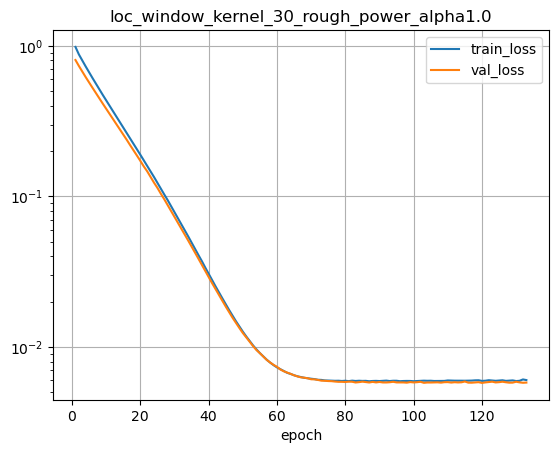

In [57]:
R = 30

if kernel_regime == "exp":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
elif kernel_regime == "yukawa":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
elif kernel_regime == "power":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"

path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)




Model loc_window_kernel_1_rough_power_alpha1.0: best val loss = 0.327459 at epoch 80
Best model: R=1, val_loss=0.327459
Model loc_window_kernel_2_rough_power_alpha1.0: best val loss = 0.177444 at epoch 63
Best model: R=2, val_loss=0.177444
Model loc_window_kernel_3_rough_power_alpha1.0: best val loss = 0.118645 at epoch 95
Best model: R=3, val_loss=0.118645
Model loc_window_kernel_4_rough_power_alpha1.0: best val loss = 0.084449 at epoch 128
Best model: R=4, val_loss=0.084449
Model loc_window_kernel_5_rough_power_alpha1.0: best val loss = 0.066223 at epoch 87
Best model: R=5, val_loss=0.066223
Model loc_window_kernel_6_rough_power_alpha1.0: best val loss = 0.052785 at epoch 78
Best model: R=6, val_loss=0.052785
Model loc_window_kernel_7_rough_power_alpha1.0: best val loss = 0.045462 at epoch 78
Best model: R=7, val_loss=0.045462
Model loc_window_kernel_8_rough_power_alpha1.0: best val loss = 0.036697 at epoch 78
Best model: R=8, val_loss=0.036697
Model loc_window_kernel_9_rough_power_a

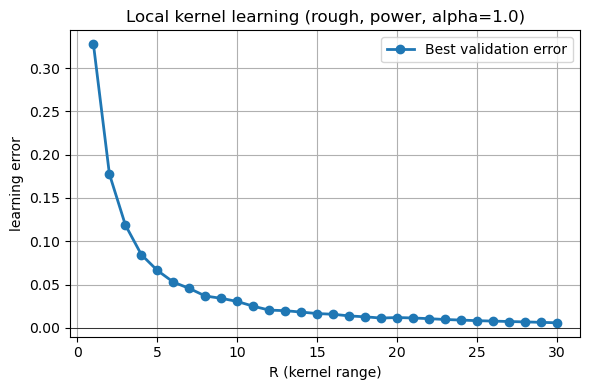

In [58]:
R_best = 0
best_val = math.inf

val_hist_R = []
learning_hist_R = []

for R in R_list:
    if kernel_regime == "exp":
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
    elif kernel_regime == "yukawa":
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
    elif kernel_regime == "power":
        run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"

    model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

    val_hist_R.append((R, val_loss))
    learning_hist_R.append((R, ))

    print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
    if val_loss < best_val:
        best_val = val_loss
        R_best = R

    print(f"Best model: R={R_best}, val_loss={best_val:.6f}")

print("Validation history:")
for R, val_loss in val_hist_R:
    print(f"R={R}: val_loss={val_loss:.6f}")



plt.figure(figsize=(6,4))
plt.plot([x[0] for x in val_hist_R], [x[1] for x in val_hist_R], 'o-', label='Best validation error', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("R (kernel range)")
plt.ylabel("learning error")
# plt.ylim((0.0, 1e-4))
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, power, alpha={alpha})")
plt.tight_layout()
plt.show()

In [59]:
class LearnableKernelConv1d(nn.Module):
    """
    Learnable 1D convolution kernel K_r with range R
    Produces phi = [K * rho] (linear convolution with padding)
    """
    def __init__(self, R=5, even_kernel=True, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.pad_mode = pad_mode
        self.even_kernel = even_kernel
        
        if even_kernel:
            # learn half + center: w[0] (center), w[1..R] (positive r)
            self.kernel_half = nn.Parameter(torch.randn(R+1) * 0.01)
        else:
            # fully unconstrained kernel of size 2R+1
            self.kernel = nn.Parameter(torch.randn(2*R+1) * 0.01)

    def build_kernel(self):
        """
        Returns kernel of shape (1,1,2R+1) as required by conv1d
        """
        if self.even_kernel:
            center = self.kernel_half[0:1]          # (1,)
            pos = self.kernel_half[1:]             # (R,)
            neg = pos.flip(0)               # symmetric
            full = torch.cat([neg, center, pos], dim=0)  # (2R+1,)
        else:
            full = self.kernel
        return full.view(1,1,-1)  # (out=1, in=1, kernel_size)

    def forward(self, rho):
        """
        rho: (B, N_grid)
        Returns: phi: (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        kernel = kernel.to(dtype=rho.dtype, device=rho.device)
        R = self.R
        
        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='constant', value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='reflect')
        else:
            raise ValueError("pad_mode must be zero or reflect")
        
        phi = F.conv1d(x, kernel, padding=0).squeeze(1)
        return phi

class KernelOnlyEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j} = (1 / 2N) * sum_{i} rho_i [K * rho]_i
    The kernel K is assumed local and learnable via convolution
    """

    def __init__(self, R=5):
        super().__init__()
        self.R = R
        self.kernel_conv = LearnableKernelConv1d(R, even_kernel=True, pad_mode="zero")

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        rho_norm = features[..., 0]          # (B, N_grid), isolate density
        rho = rho_norm * std_feat[0,0,0] + mean_feat[0,0,0]  # denormalize density

        # apply learnable convolution kernel
        phi = self.kernel_conv(rho)  # (B, N_grid) # in physical units

        local_energies = 0.5 * rho * phi       # (B, N_grid) # physical units
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,) # physical units
        
        total_energy_norm = (total_energy - E_mean) / E_std  # normalize for training

        return total_energy_norm
    
class GaussianMixtureKernelConv1d(nn.Module):
    """
    Learnable 1D kernel K_r represented as a sum of Gaussians:
        K(r) = sum_{n=1}^M A_n * exp(-r^2 / sigma_n^2)

    Produces phi = [K * rho] via conv1d.
    """

    def __init__(self, R: int, n_components: int, pad_mode: str = "zero"):
        super().__init__()
        self.R = R
        self.n_components = n_components
        self.pad_mode = pad_mode

        # r-grid as a buffer: [-R, ..., R] - still is a cutoff in real space
        r_vals = torch.arange(-R, R + 1, dtype=dtype)
        self.register_buffer("r_vals", r_vals)  # (2R+1,)

        # ---- amplitudes A_n (sorted at init) ----
        # sample, then sort descending so A_1 >= A_2 >= ... >= A_M
        amps = 0.01 * torch.randn(n_components, dtype=dtype)
        amps, _ = torch.sort(amps, descending=True)
        self.amplitudes = nn.Parameter(amps)

        # Log-sigmas so sigma_n = softplus(log_sigma_n) > 0
        init_sigmas = torch.arange(1, n_components+1, dtype=dtype)**2
        log_sigmas = torch.log(torch.expm1(init_sigmas))  # inverse softplus, so softplus(raw)=init_sigma
        self.log_sigmas = nn.Parameter(log_sigmas)

    def build_kernel(self):
        """
        Returns kernel of shape (1, 1, 2R+1) as required by conv1d.
        """
        # (2R+1,) -> (1, L)
        r = self.r_vals.view(1, -1)              # (1, 2R+1)
        r2 = r * r                               # r^2

        sigmas = F.softplus(self.log_sigmas) + 1e-8   # (M,)
        sigma2 = sigmas.view(-1, 1) ** 2              # (M,1)

        # contributions from each Gaussian: (M, L)
        # exp(-r^2 / sigma_n^2)
        gauss = torch.exp(-r2 / sigma2)          # (M, 2R+1)

        # weighted sum over components
        kernel_1d = (self.amplitudes.view(-1, 1) * gauss).sum(dim=0)  # (2R+1,)

        # conv1d expects (out_channels, in_channels, kernel_size)
        return kernel_1d.view(1, 1, -1)

    def forward(self, rho: torch.Tensor) -> torch.Tensor:
        """
        rho: (B, N_grid)
        Returns: phi = (K * rho): (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        R = self.R

        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="constant", value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="reflect")
        else:
            raise ValueError("pad_mode must be 'zero' or 'reflect'")

        phi = F.conv1d(x, kernel, padding=0).squeeze(1)   # (B, N)
        return phi


class GaussianMixtureEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j}
          = (1 / 2N) * sum_i rho_i [K * rho]_i

    K is parameterized as a sum of Gaussians in r.
    """

    def __init__(self, R=20, n_components=3, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.kernel_conv = GaussianMixtureKernelConv1d(
            R=R,
            n_components=n_components,
            pad_mode=pad_mode,
        )

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used

        Returns:
            total_energy_norm: (B,) - normalized total energy
        """
        # globals: std_feat, mean_feat, E_mean, E_std, N_grid must exist
        rho_norm = features[..., 0]          # (B, N_grid)
        rho = rho_norm * std_feat[0, 0, 0] + mean_feat[0, 0, 0]

        # apply Gaussian-mixture kernel
        phi = self.kernel_conv(rho)          # (B, N_grid)

        local_energies = 0.5 * rho * phi     # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid    # (B,)

        total_energy_norm = (total_energy - E_mean) / E_std
        return total_energy_norm

Evaluate performance of training

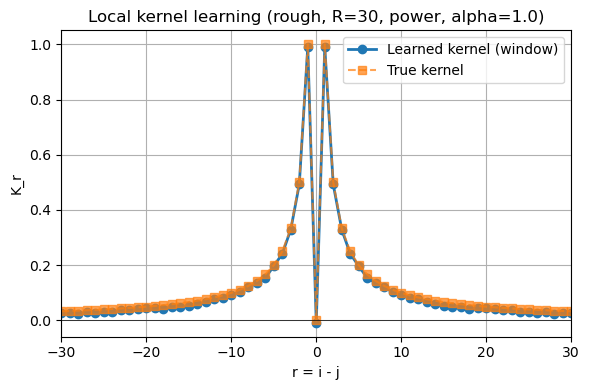

In [60]:

R = 30
if kernel_regime == "exp":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_xi{xi}"
elif kernel_regime == "yukawa":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_lam{lam}"
elif kernel_regime == "power":
    run_name = f"loc_window_kernel_{R}_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}"
model, normalization, epoch, val_loss = load_checkpoint(ckpt_dir + f"/{run_name}_best.pt", KernelOnlyEnergyNN, device=device)

with torch.no_grad():
    k_full = model.kernel_conv.build_kernel().view(-1).cpu().numpy() 

r_grid = np.arange(-R, R+1)

if kernel_regime == "exp":
    def K_true(r):
        return np.exp(-np.abs(r) / xi)
elif kernel_regime == "yukawa":
    def K_true(r):
        r_abs = np.abs(r)
        out = np.exp(-r_abs / lam) / np.maximum(r_abs, 1.0)
        return out * (r_abs > 0)
elif kernel_regime == "power":
    def K_true(r):
        r_abs = np.abs(r)
        out = 1.0 / (np.maximum(r_abs, 1.0)**alpha)
        return out * (r_abs > 0)    

k_true = K_true(r_grid)

plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full , 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, k_true, 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, R={R}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, R={R}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, R={R}, power, alpha={alpha})")
plt.tight_layout()
plt.show()

In [61]:
class LearnableKernelConv1d(nn.Module):
    """
    Learnable 1D convolution kernel K_r with range R
    Produces phi = [K * rho] (linear convolution with padding)
    """
    def __init__(self, R=5, even_kernel=True, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.pad_mode = pad_mode
        self.even_kernel = even_kernel
        
        if even_kernel:
            # learn half + center: w[0] (center), w[1..R] (positive r)
            self.kernel_half = nn.Parameter(torch.randn(R+1) * 0.01)
        else:
            # fully unconstrained kernel of size 2R+1
            self.kernel = nn.Parameter(torch.randn(2*R+1) * 0.01)

    def build_kernel(self):
        """
        Returns kernel of shape (1,1,2R+1) as required by conv1d
        """
        if self.even_kernel:
            center = self.kernel_half[0:1]          # (1,)
            pos = self.kernel_half[1:]             # (R,)
            neg = pos.flip(0)               # symmetric
            full = torch.cat([neg, center, pos], dim=0)  # (2R+1,)
        else:
            full = self.kernel
        return full.view(1,1,-1)  # (out=1, in=1, kernel_size)

    def forward(self, rho):
        """
        rho: (B, N_grid)
        Returns: phi: (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        kernel = kernel.to(dtype=rho.dtype, device=rho.device)
        R = self.R
        
        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='constant', value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode='reflect')
        else:
            raise ValueError("pad_mode must be zero or reflect")
        
        phi = F.conv1d(x, kernel, padding=0).squeeze(1)
        return phi

class KernelOnlyEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j} = (1 / 2N) * sum_{i} rho_i [K * rho]_i
    The kernel K is assumed local and learnable via convolution
    """

    def __init__(self, R=5):
        super().__init__()
        self.R = R
        self.kernel_conv = LearnableKernelConv1d(R, even_kernel=True, pad_mode="zero")

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        rho_norm = features[..., 0]          # (B, N_grid), isolate density
        rho = rho_norm * std_feat[0,0,0] + mean_feat[0,0,0]  # denormalize density

        # apply learnable convolution kernel
        phi = self.kernel_conv(rho)  # (B, N_grid) # in physical units

        local_energies = 0.5 * rho * phi       # (B, N_grid) # physical units
        total_energy = local_energies.sum(dim=1) / N_grid       # (B,) # physical units
        
        total_energy_norm = (total_energy - E_mean) / E_std  # normalize for training

        return total_energy_norm
    
class GaussianMixtureKernelConv1d(nn.Module):
    """
    Learnable 1D kernel K_r represented as a sum of Gaussians:
        K(r) = sum_{n=1}^M A_n * exp(-r^2 / sigma_n^2)

    Produces phi = [K * rho] via conv1d.
    """

    def __init__(self, R: int, n_components: int, pad_mode: str = "zero"):
        super().__init__()
        self.R = R
        self.n_components = n_components
        self.pad_mode = pad_mode

        # r-grid as a buffer: [-R, ..., R] - still is a cutoff in real space
        r_vals = torch.arange(-R, R + 1, dtype=dtype)
        self.register_buffer("r_vals", r_vals)  # (2R+1,)

        # ---- amplitudes A_n (sorted at init) ----
        # sample, then sort descending so A_1 >= A_2 >= ... >= A_M
        amps = 0.01 * torch.randn(n_components, dtype=dtype)
        amps, _ = torch.sort(amps, descending=True)
        self.amplitudes = nn.Parameter(amps)

        # Log-sigmas so sigma_n = softplus(log_sigma_n) > 0
        init_sigmas = torch.arange(1, n_components+1, dtype=dtype)**2
        log_sigmas = torch.log(torch.expm1(init_sigmas))  # inverse softplus, so softplus(raw)=init_sigma
        self.log_sigmas = nn.Parameter(log_sigmas)

    def build_kernel(self):
        """
        Returns kernel of shape (1, 1, 2R+1) as required by conv1d.
        """
        # (2R+1,) -> (1, L)
        r = self.r_vals.view(1, -1)              # (1, 2R+1)
        r2 = r * r                               # r^2

        sigmas = F.softplus(self.log_sigmas) + 1e-8   # (M,)
        sigma2 = sigmas.view(-1, 1) ** 2              # (M,1)

        # contributions from each Gaussian: (M, L)
        # exp(-r^2 / sigma_n^2)
        gauss = torch.exp(-r2 / sigma2)          # (M, 2R+1)

        # weighted sum over components
        kernel_1d = (self.amplitudes.view(-1, 1) * gauss).sum(dim=0)  # (2R+1,)

        # conv1d expects (out_channels, in_channels, kernel_size)
        return kernel_1d.view(1, 1, -1)

    def forward(self, rho: torch.Tensor) -> torch.Tensor:
        """
        rho: (B, N_grid)
        Returns: phi = (K * rho): (B, N_grid)
        """
        B, N = rho.shape
        kernel = self.build_kernel()
        R = self.R

        if self.pad_mode == "zero":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="constant", value=0.0)
        elif self.pad_mode == "reflect":
            x = F.pad(rho.unsqueeze(1), (R, R), mode="reflect")
        else:
            raise ValueError("pad_mode must be 'zero' or 'reflect'")

        phi = F.conv1d(x, kernel, padding=0).squeeze(1)   # (B, N)
        return phi


class GaussianMixtureEnergyNN(nn.Module):
    """
    E_tot = (1 / 2N) * sum_{i,j} rho_i rho_j K_{i-j}
          = (1 / 2N) * sum_i rho_i [K * rho]_i

    K is parameterized as a sum of Gaussians in r.
    """

    def __init__(self, R=20, n_components=3, pad_mode="zero"):
        super().__init__()
        self.R = R
        self.kernel_conv = GaussianMixtureKernelConv1d(
            R=R,
            n_components=n_components,
            pad_mode=pad_mode,
        )

    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat) - only the first feature (density) is used

        Returns:
            total_energy_norm: (B,) - normalized total energy
        """
        # globals: std_feat, mean_feat, E_mean, E_std, N_grid must exist
        rho_norm = features[..., 0]          # (B, N_grid)
        rho = rho_norm * std_feat[0, 0, 0] + mean_feat[0, 0, 0]

        # apply Gaussian-mixture kernel
        phi = self.kernel_conv(rho)          # (B, N_grid)

        local_energies = 0.5 * rho * phi     # (B, N_grid)
        total_energy = local_energies.sum(dim=1) / N_grid    # (B,)

        total_energy_norm = (total_energy - E_mean) / E_std
        return total_energy_norm